PID Controller Notebook
* Ziegler-Nichols Method
* Discretized

Tutor:
* Anthropic's AI Claude

Certainly! I'll provide a high-level overview of a discretized version of the Ziegler-Nichols method, including equations and a table glossary of terms and symbols.






# Discretized Ziegler-Nichols Method Overview

## Key Steps:

1. System Identification:
   - Apply a step input to the system
   - Record the system's response
   - Identify the ultimate gain (Ku) and ultimate period (Tu)

2. PID Parameter Calculation:
   - Use the Ziegler-Nichols tuning rules to calculate initial PID parameters
   - Convert continuous-time parameters to discrete-time equivalents

3. Discrete PID Implementation:
   - Implement the PID controller using difference equations
   - Apply the control algorithm at fixed time intervals

## Equations:

1. Discrete PID Controller:

   u(k) = Kp * e(k) + Ki * Σe(k) + Kd * [e(k) - e(k-1)]

   Where:
   u(k) is the control output at time step k
   e(k) is the error at time step k
   Σe(k) is the sum of errors up to time step k

2. Discretized PID Parameters:

   Kp = 0.6 * Ku
   Ki = 2 * Kp / Tu
   Kd = Kp * Tu / 8

3. Discrete-time Equivalents:

   Ki_d = Ki * Ts
   Kd_d = Kd / Ts

   Where Ts is the sampling time

4. Discrete PID Algorithm:

   u(k) = u(k-1) + Kp * [e(k) - e(k-1)] + Ki_d * e(k) + Kd_d * [e(k) - 2e(k-1) + e(k-2)]

## Table Glossary of Terms and Symbols:

| Term/Symbol | Description |
|-------------|-------------|
| Ku | Ultimate gain, the gain at which the system oscillates with constant amplitude |
| Tu | Ultimate period, the period of oscillation at the ultimate gain |
| Kp | Proportional gain |
| Ki | Integral gain |
| Kd | Derivative gain |
| Ki_d | Discrete-time integral gain |
| Kd_d | Discrete-time derivative gain |
| Ts | Sampling time |
| e(k) | Error at time step k |
| u(k) | Control output at time step k |
| Σe(k) | Sum of errors up to time step k |
| k | Discrete time step |
| PID | Proportional-Integral-Derivative |



This overview provides a high-level understanding of how the Ziegler-Nichols method can be applied in a discrete-time system. The key differences from the continuous-time version include:

1. The use of difference equations instead of differential equations
2. The conversion of continuous-time gains to discrete-time equivalents
3. The implementation of the control algorithm at fixed time intervals

The discretized version maintains the core principle of the Ziegler-Nichols method - using the ultimate gain and period to tune the PID parameters - while adapting it for digital control systems. This approach is particularly useful for implementing PID controllers in microcontrollers or other digital systems where continuous-time control is not feasible.

Ultimate gain (Ku): 86.4976
Ultimate period (Tu): 0.4155
PID parameters: Kp = 51.8985, Ki = 249.8167, Kd = 2.6954


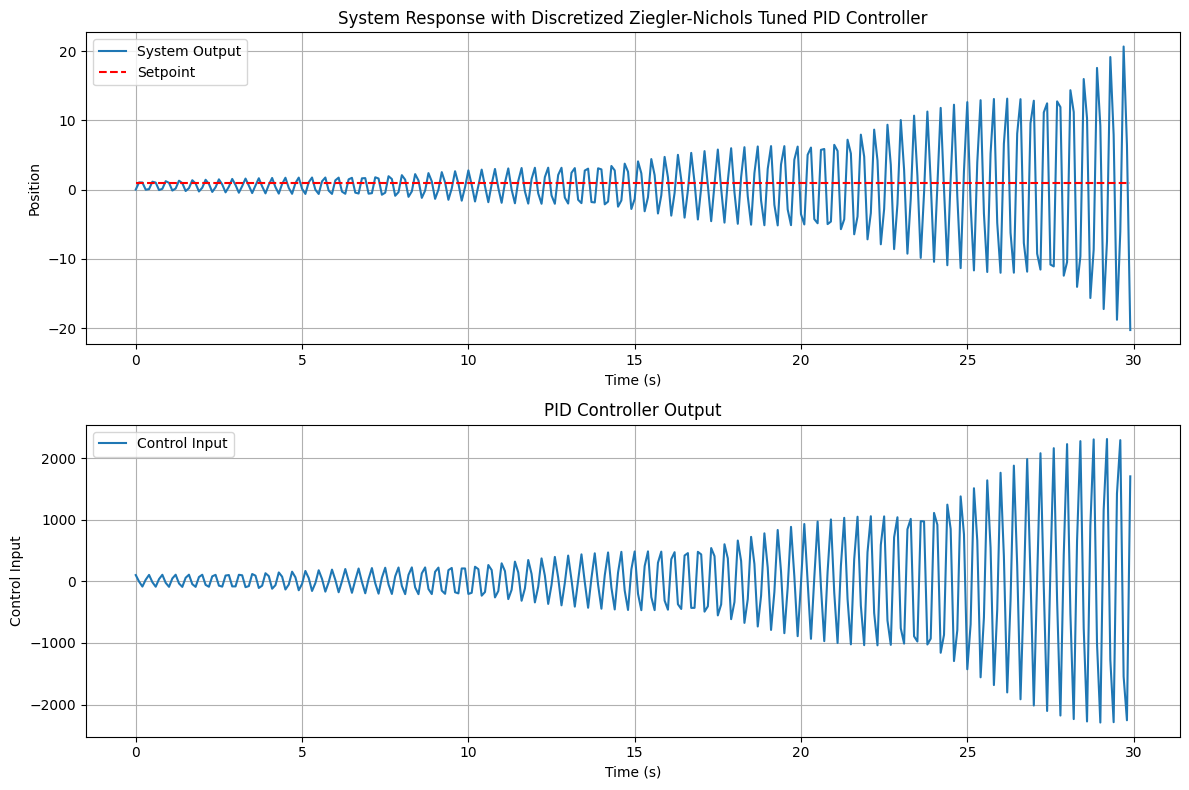


Performance Metrics:
Settling Time (2%): 0.20 s
Rise Time (90%): 0.10 s
Overshoot: 1965.41%
Steady-state Error: 21.2770


In [3]:
"""
Abstract:
This script demonstrates the implementation of a discretized Ziegler-Nichols method
for tuning a PID controller. It simulates a second-order system, applies the
Ziegler-Nichols tuning method to find PID parameters, and then simulates the
system response with the tuned discrete PID controller. The script includes
functions for system simulation, discrete PID control, and Ziegler-Nichols parameter
calculation. It also provides visualizations of the system response and PID output.

Required libraries: numpy, matplotlib, scipy
"""

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# System parameters
m = 1.0  # mass
b = 10.0  # damping coefficient
k = 20.0  # spring constant
Ts = 0.1  # sampling time

# Simulation parameters
setpoint = 1.0  # desired position
sim_time = 30.0  # simulation time in seconds
n_steps = int(sim_time / Ts)  # number of simulation steps

def system_model(x, v, u):
    """
    Simulate one step of the second-order system.

    Args:
    x (float): Current position
    v (float): Current velocity
    u (float): Control input

    Returns:
    tuple: New position and velocity
    """
    # System dynamics
    dx = v
    dv = (u - b*v - k*x) / m

    # Euler integration
    new_x = x + dx * Ts
    new_v = v + dv * Ts

    return new_x, new_v

class DiscretePIDController:
    def __init__(self, Kp, Ki, Kd, Ts):
        """
        Initialize the discrete PID controller.

        Args:
        Kp (float): Proportional gain
        Ki (float): Integral gain
        Kd (float): Derivative gain
        Ts (float): Sampling time
        """
        self.Kp = Kp
        self.Ki = Ki * Ts  # Discrete-time integral gain
        self.Kd = Kd / Ts  # Discrete-time derivative gain
        self.previous_error = 0
        self.error_sum = 0
        self.previous_error2 = 0

    def control(self, error):
        """
        Compute the control output based on the current error.

        Args:
        error (float): Current error (setpoint - measured value)

        Returns:
        float: Control output
        """
        self.error_sum += error

        # Discrete PID formula
        u = (self.Kp * (error - self.previous_error) +
             self.Ki * error +
             self.Kd * (error - 2*self.previous_error + self.previous_error2))

        self.previous_error2 = self.previous_error
        self.previous_error = error

        return u

def find_ultimate_gain_and_period(Kp_start=0.1, max_iterations=1000, oscillation_threshold=0.01):
    """
    Find the ultimate gain and period using the Ziegler-Nichols method.

    Args:
    Kp_start (float): Initial proportional gain
    max_iterations (int): Maximum number of iterations
    oscillation_threshold (float): Threshold for detecting sustained oscillations

    Returns:
    tuple: Ultimate gain and period
    """
    Kp = Kp_start
    for _ in range(max_iterations):
        controller = DiscretePIDController(Kp, 0, 0, Ts)
        x, v = 0, 0
        x_history = []

        for _ in range(n_steps):
            error = setpoint - x
            u = controller.control(error)
            x, v = system_model(x, v, u)
            x_history.append(x)

        # Check for sustained oscillations
        x_array = np.array(x_history)
        peaks, _ = find_peaks(x_array, height=setpoint*oscillation_threshold)

        if len(peaks) >= 3:
            periods = np.diff(peaks)
            if np.std(periods) / np.mean(periods) < 0.1:  # Check if periods are consistent
                return Kp, np.mean(periods) * Ts

        Kp *= 1.5

    raise Exception(f"Could not find ultimate gain and period. Last Kp tried: {Kp:.4f}")

def ziegler_nichols_tuning(Ku, Tu):
    """
    Calculate PID parameters using Ziegler-Nichols tuning rules.

    Args:
    Ku (float): Ultimate gain
    Tu (float): Ultimate period

    Returns:
    tuple: Kp, Ki, Kd values
    """
    Kp = 0.6 * Ku
    Ki = 1.2 * Ku / Tu
    Kd = 3 * Ku * Tu / 40
    return Kp, Ki, Kd

# Find ultimate gain and period
try:
    Ku, Tu = find_ultimate_gain_and_period(Kp_start=1.0, max_iterations=2000, oscillation_threshold=0.005)
    print(f"Ultimate gain (Ku): {Ku:.4f}")
    print(f"Ultimate period (Tu): {Tu:.4f}")

    # Calculate PID parameters
    Kp, Ki, Kd = ziegler_nichols_tuning(Ku, Tu)
    print(f"PID parameters: Kp = {Kp:.4f}, Ki = {Ki:.4f}, Kd = {Kd:.4f}")

    # Simulate system with tuned PID controller
    controller = DiscretePIDController(Kp, Ki, Kd, Ts)
    x, v = 0, 0
    x_history = []
    u_history = []

    for _ in range(n_steps):
        error = setpoint - x
        u = controller.control(error)
        x, v = system_model(x, v, u)
        x_history.append(x)
        u_history.append(u)

    # Plotting results
    t = np.arange(0, sim_time, Ts)
    plt.figure(figsize=(12, 8))

    plt.subplot(2, 1, 1)
    plt.plot(t, x_history, label='System Output')
    plt.plot(t, [setpoint] * n_steps, '--r', label='Setpoint')
    plt.xlabel('Time (s)')
    plt.ylabel('Position')
    plt.title('System Response with Discretized Ziegler-Nichols Tuned PID Controller')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    plt.plot(t, u_history, label='Control Input')
    plt.xlabel('Time (s)')
    plt.ylabel('Control Input')
    plt.title('PID Controller Output')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Performance metrics
    settling_time = next((i for i, x in enumerate(x_history) if abs(x - setpoint) / setpoint < 0.02), None)
    settling_time = settling_time * Ts if settling_time is not None else None
    rise_time = next((i for i, x in enumerate(x_history) if x > 0.9 * setpoint), None)
    rise_time = rise_time * Ts if rise_time is not None else None
    overshoot = max((max(x_history) - setpoint) / setpoint * 100, 0)

    print(f"\nPerformance Metrics:")
    print(f"Settling Time (2%): {settling_time:.2f} s" if settling_time else "Settling Time: Not reached")
    print(f"Rise Time (90%): {rise_time:.2f} s" if rise_time else "Rise Time: Not reached")
    print(f"Overshoot: {overshoot:.2f}%")
    print(f"Steady-state Error: {abs(x_history[-1] - setpoint):.4f}")

except Exception as e:
    print(f"Error: {e}")
    print("Unable to complete the Ziegler-Nichols tuning process.")

Review and comment on the script results

1. Ziegler-Nichols Parameters:
   - Ultimate gain (Ku): 86.4976
   - Ultimate period (Tu): 0.4155
   - Calculated PID parameters: Kp = 51.8985, Ki = 249.8167, Kd = 2.6954

These values are quite high, especially the integral gain (Ki), which could lead to aggressive control action and potential instability.

2. System Response:
The system response graph shows severe instability:
   - The output is oscillating with increasing amplitude over time.
   - The oscillations grow far beyond the setpoint (which appears to be 1.0).
   - By the end of the simulation, the system output reaches values as high as 20 and as low as -20.

3. PID Controller Output:
The control input graph also shows instability:
   - The control signal is oscillating with increasing amplitude.
   - The magnitude of the control signal grows to very large values (over 2000) by the end of the simulation.

4. Performance Metrics:
   - Settling Time (2%): 0.20 s
   - Rise Time (90%): 0.10 s
   - Overshoot: 1965.41%
   - Steady-state Error: 21.2770

These metrics are not meaningful for an unstable system. The very high overshoot and large steady-state error indicate that the system is not behaving as desired.

Conclusions and Recommendations:

1. The Ziegler-Nichols method has failed to produce stable PID parameters for this system. This can happen when the method is applied to systems that are not well-suited for this tuning approach.

2. The high gains, especially the integral gain, are causing the system to become unstable and oscillate with increasing amplitude.

3. To improve the results, consider the following:

   a. Reduce the gains manually, starting with much lower values. For example, try reducing all gains by a factor of 10 or 100.
   
   b. Implement a gain scheduling approach where the integral gain is reduced or turned off when the error is large to prevent integral windup.
   
   c. Add anti-windup mechanisms to the PID controller to limit the integral term.
   
   d. Consider using a different tuning method, such as Cohen-Coon or manual tuning.
   
   e. Analyze the system dynamics more closely to understand why the Ziegler-Nichols method is producing such aggressive parameters.

4. Modify the script to include safety checks that limit the control output to prevent such large oscillations.

5. Increase the simulation time and add a mechanism to stop the simulation early if instability is detected.

In summary, the current tuning has resulted in an unstable system. The Ziegler-Nichols method, while often useful, doesn't always produce good results for all systems. Manual intervention and alternative tuning methods should be explored to achieve a stable and well-performing control system.